In [142]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn

import xgboost as xgb
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import GridSearchCV
color_pal = sns.color_palette()
plt.style.use('fivethirtyeight')

In [143]:
df = pd.read_csv('DailyDelhiClimateTrain.csv')

In [144]:
#For now, we will not work with the mean pressure variable

df = df.drop('meanpressure', axis=1)

In [145]:
#2017 had only one date in our current dataset. Because of this, we will remove that row,
#since it is not representative of that whole year, which could harm the model's prediction.

df = df.loc[(df['date'] != '2017-01-01')]

In [146]:
#Transforming the date column into date format and setting it as the set index.

df = df.set_index('date')
df.index = pd.to_datetime(df.index)

In [147]:
#Preparing each dataset

dfTEMP = df.drop(['humidity', 'wind_speed'], axis=1)
dfHUM = df.drop(['meantemp', 'wind_speed'], axis=1)
dfWIND = df.drop(['humidity', 'meantemp'], axis=1)

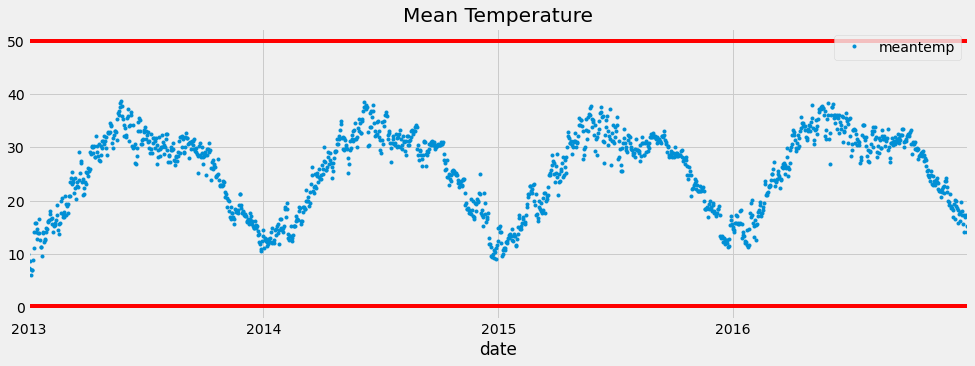

,meantemp
count,1461.000000
mean,25.506127
std,7.339416
min,6.000000
25%,18.857143
50%,27.714286
75%,31.312500
max,38.714286


In [79]:
#checking for outliers using inter quartile range for each dataset

dfTEMP.plot(style='.',
        figsize=(15, 5),
        color=color_pal[0],
        title='Mean Temperature')
plt.axhline(y=(np.percentile(dfTEMP, 75) + (1.5*(np.percentile(dfTEMP, 75)-np.percentile(dfTEMP, 25)))), color='r')
plt.axhline(y=(np.percentile(dfTEMP, 25) - (1.5*(np.percentile(dfTEMP, 75)-np.percentile(dfTEMP, 25)))), color='r')

plt.show()

dfTEMP.describe()

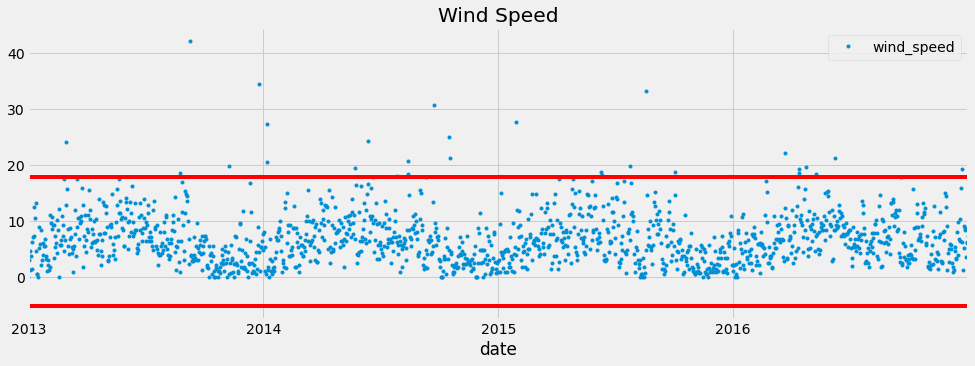

,wind_speed
count,1461.000000
mean,6.806865
std,4.559688
min,0.000000
25%,3.475000
50%,6.250000
75%,9.250000
max,42.220000


In [80]:
dfWIND.plot(style='.',
        figsize=(15, 5),
        color=color_pal[0],
        title='Wind Speed')
plt.axhline(y=(np.percentile(dfWIND, 75) + (1.5*(np.percentile(dfWIND, 75)-np.percentile(dfWIND, 25)))), color='r')
plt.axhline(y=(np.percentile(dfWIND, 25) - (1.5*(np.percentile(dfWIND, 75)-np.percentile(dfWIND, 25)))), color='r')


plt.show()

dfWIND.describe()

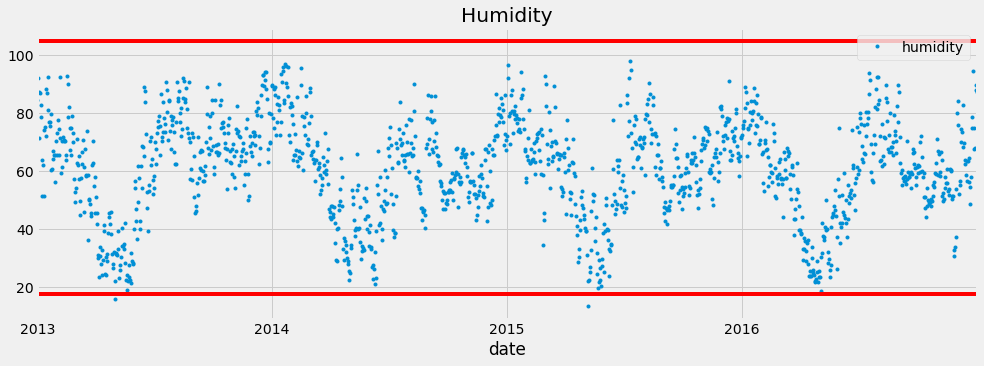

50.375

In [81]:
dfHUM.plot(style='.',
        figsize=(15, 5),
        color=color_pal[0],
        title='Humidity')

plt.axhline(y=(np.percentile(dfHUM, 75) + (1.5*(np.percentile(dfHUM, 75)-np.percentile(dfHUM, 25)))), color='r')
plt.axhline(y=(np.percentile(dfHUM, 25) - (1.5*(np.percentile(dfHUM, 75)-np.percentile(dfHUM, 25)))), color='r')

plt.show()

dfHUM.describe()

np.percentile(dfHUM, 25) 

In [148]:
 #Removing the outliers
dfTEMP = dfTEMP.loc[(dfTEMP['meantemp'] < (np.percentile(dfTEMP, 75) + (1.5*(np.percentile(dfTEMP, 75)-np.percentile(dfTEMP, 25))))) & 
                    (dfTEMP['meantemp'] > (np.percentile(dfTEMP, 25) - (1.5*(np.percentile(dfTEMP, 75)-np.percentile(dfTEMP, 25)))))]
dfHUM = dfHUM.loc[(dfHUM['humidity'] < (np.percentile(dfHUM, 75) + (1.5*(np.percentile(dfHUM, 75)-np.percentile(dfHUM, 25))))) & 
                  (dfHUM['humidity'] > (np.percentile(dfHUM, 25) - (1.5*(np.percentile(dfHUM, 75)-np.percentile(dfHUM, 25)))))]
dfWIND = dfWIND.loc[(dfWIND['wind_speed'] < (np.percentile(dfWIND, 75) + (1.5*(np.percentile(dfWIND, 75)-np.percentile(dfWIND, 25))))) & 
                    (dfWIND['wind_speed'] > (np.percentile(dfWIND, 25) - (1.5*(np.percentile(dfWIND, 75)-np.percentile(dfWIND, 25)))))]
    

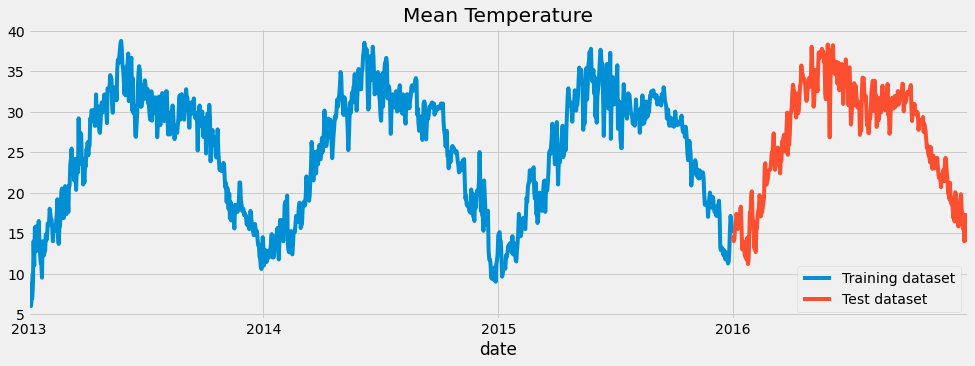

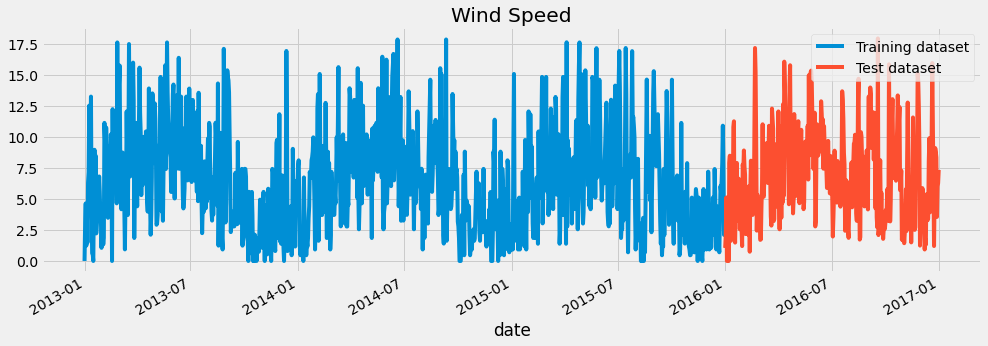

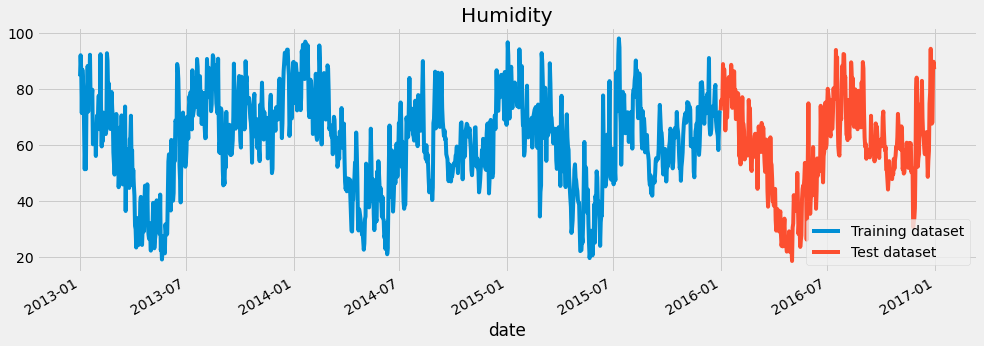

In [149]:
#Setting the training and testing datasets in a simple way: 
#everything after 01-01-2016 will be our testing dataset, and the rest will be used for training

TEMP_train = dfTEMP.loc[dfTEMP.index < '01-01-2016']
TEMP_test = dfTEMP.loc[dfTEMP.index >= '01-01-2016']

fig, ax = plt.subplots(figsize=(15, 5))
TEMP_train.plot(ax=ax, label='Training', title='Mean Temperature')
TEMP_test.plot(ax=ax, label='Test')
ax.legend(['Training dataset', 'Test dataset'])
plt.show()


WIND_train = dfWIND.loc[dfWIND.index < '01-01-2016']
WIND_test = dfWIND.loc[dfWIND.index >= '01-01-2016']

fig, ax = plt.subplots(figsize=(15, 5))
WIND_train.plot(ax=ax, label='Training',  title='Wind Speed')
WIND_test.plot(ax=ax, label='Test')
ax.legend(['Training dataset', 'Test dataset'])
plt.show()


HUM_train = dfHUM.loc[dfHUM.index < '01-01-2016']
HUM_test = dfHUM.loc[dfHUM.index >= '01-01-2016']

fig, ax = plt.subplots(figsize=(15, 5))
HUM_train.plot(ax=ax, label='Training', title='Humidity')
HUM_test.plot(ax=ax, label='Test')
ax.legend(['Training dataset', 'Test dataset'])
plt.show()



In [150]:
#Creating a function that creates our time series features

def create_features(df):
    df = df.copy()
    df['dayofweek'] = df.index.dayofweek
    df['quarter'] = df.index.quarter
    df['month'] = df.index.month
    df['year'] = df.index.year
    df['dayofmonth'] = df.index.day
    df['weekofyear'] = df.index.isocalendar().week
    df = df.astype({'weekofyear':'int'})
    return df

TEMP_train = create_features(TEMP_train)
TEMP_test = create_features(TEMP_test)

WIND_train = create_features(WIND_train)
WIND_test = create_features(WIND_test)

HUM_train = create_features(HUM_train)
HUM_test = create_features(HUM_test)

In [151]:
#Creating the input and output datasets for each variable.

TEMP_input_test = TEMP_test.drop(['meantemp'], axis=1)
TEMP_output_test = TEMP_test[['meantemp']]
TEMP_input_train = TEMP_train.drop(['meantemp'], axis=1)
TEMP_output_train = TEMP_train[['meantemp']]

HUM_input_test = HUM_test.drop(['humidity'], axis=1)
HUM_output_test = HUM_test[['humidity']]
HUM_input_train = HUM_train.drop(['humidity'], axis=1)
HUM_output_train = HUM_train[['humidity']]

WIND_input_test = WIND_test.drop(['wind_speed'], axis=1)
WIND_output_test = WIND_test[['wind_speed']]
WIND_input_train = WIND_train.drop(['wind_speed'], axis=1)
WIND_output_train = WIND_train[['wind_speed']]

In [20]:
#Searching for the best max_depth, learning rate and n of trees hyperparameters among the pre-selected
#groups using grid search.

print("\n==============START GRID SEARCH FOR TEMP==================\n")
params = { 'max_depth': [3,6,10],
           'learning_rate': [0.0001, 0.001, 0.01, 0.05, 0.1],
           'n_estimators': [100, 500, 1000, 1500, 2000]
         }
reg = xgb.XGBRegressor(seed = 42)
opt = GridSearchCV(estimator=reg, 
                   param_grid=params,
                   scoring='neg_mean_squared_error', 
                   verbose=1)
opt.fit(TEMP_input_train, TEMP_output_train)
print("\nBest Parameters according to Grid Search:", opt.best_params_)
print("\n==============END GRID SEARCH FOR TEMP==================\n")


==============START GRID SEARCH FOR TEMP==================

Fitting 5 folds for each of 75 candidates, totalling 375 fits

Best Parameters according to Grid Search: {'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 500}

==============END GRID SEARCH FOR TEMP==================



==============TEMP - TRAINING WITH THE BEST PARAMETERS==================

[0]	validation_0-rmse:25.31691	validation_1-rmse:27.22713
[10]	validation_0-rmse:22.93442	validation_1-rmse:24.85010
[20]	validation_0-rmse:20.78151	validation_1-rmse:22.70293
[30]	validation_0-rmse:18.83535	validation_1-rmse:20.76170
[40]	validation_0-rmse:17.07572	validation_1-rmse:19.00744
[50]	validation_0-rmse:15.48564	validation_1-rmse:17.42152
[60]	validation_0-rmse:14.04994	validation_1-rmse:15.99036
[70]	validation_0-rmse:12.75469	validation_1-rmse:14.69677
[80]	validation_0-rmse:11.58553	validation_1-rmse:13.53078
[90]	validation_0-rmse:10.53087	validation_1-rmse:12.47793
[100]	validation_0-rmse:9.58070	validation_1-rmse:11.52483
[110]	validation_0-rmse:8.72526	validation_1-rmse:10.65910
[120]	validation_0-rmse:7.95462	validation_1-rmse:9.88330
[130]	validation_0-rmse:7.26149	validation_1-rmse:9.18615
[140]	validation_0-rmse:6.63883	validation_1-rmse:8.55982
[150]	validation_0-rmse:6.07917	validation_1-

C:\Users\artur\AppData\Local\Temp/ipykernel_7228/3580922261.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  TEMP_output_test['meantemp_prediction'] = regT.predict(TEMP_input_test)


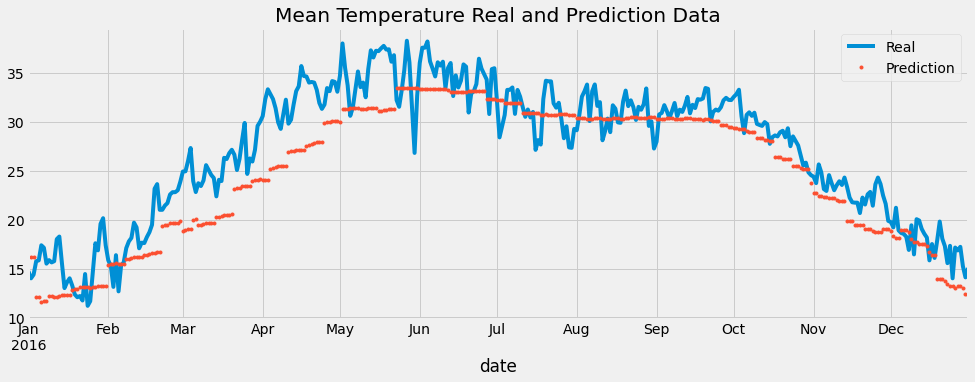

In [152]:
#Training the temperature dataset with the best parameters previsously found.

print("==============TEMP - TRAINING WITH THE BEST PARAMETERS==================\n")
regT = xgb.XGBRegressor(booster='gbtree',    
                       n_estimators=500,
                       objective='reg:squarederror',
                       max_depth=3,
                       learning_rate=0.01,
                       random_state=42)
regT.fit(TEMP_input_train, TEMP_output_train,
        eval_set=[(TEMP_input_train, TEMP_output_train), (TEMP_input_test, TEMP_output_test)],
        verbose=10)
TEMP_output_test['meantemp_prediction'] = regT.predict(TEMP_input_test)
print("Mean Squared Error = ", mean_squared_error(TEMP_output_test['meantemp'], TEMP_output_test['meantemp_prediction']))
print("\nMean Absolute Error = ", mean_absolute_error(TEMP_output_test['meantemp'], TEMP_output_test['meantemp_prediction']))

TEMP_test = TEMP_test.merge(TEMP_output_test[['meantemp_prediction']] , how='left', left_index=True, right_index=True)
ax = TEMP_test[['meantemp']].plot(figsize=(15, 5))
TEMP_test['meantemp_prediction'].plot(ax=ax, style='.')
plt.legend(['Real', 'Prediction'])
ax.set_title('Mean Temperature Real and Prediction Data')
plt.show()

In [21]:
#Searching for the best max_depth, learning rate and n of trees hyperparameters among the pre-selected
#groups using grid search.

print("\n==============START GRID SEARCH FOR HUM==================\n")
params = { 'max_depth': [3,6,10],
           'learning_rate': [0.0001, 0.001, 0.01, 0.05, 0.1],
           'n_estimators': [100, 500, 1000, 1500, 2000]
         }
reg = xgb.XGBRegressor(seed = 42)
opt = GridSearchCV(estimator=reg, 
                   param_grid=params,
                   scoring='neg_mean_squared_error', 
                   verbose=1)
opt.fit(HUM_input_train, HUM_output_train)
print("\nBest Parameters according to Grid Search:", opt.best_params_)
print("\n==============END GRID SEARCH FOR HUM==================\n")


==============START GRID SEARCH FOR HUM==================

Fitting 5 folds for each of 75 candidates, totalling 375 fits

Best Parameters according to Grid Search: {'learning_rate': 0.05, 'max_depth': 3, 'n_estimators': 100}

==============END GRID SEARCH FOR HUM==================



==============HUM - TRAINING WITH THE BEST PARAMETERS==================

[0]	validation_0-rmse:63.17442	validation_1-rmse:60.47062
[10]	validation_0-rmse:62.56962	validation_1-rmse:59.88450
[20]	validation_0-rmse:61.97101	validation_1-rmse:59.30443
[30]	validation_0-rmse:61.37854	validation_1-rmse:58.73035
[40]	validation_0-rmse:60.79214	validation_1-rmse:58.16221
[50]	validation_0-rmse:60.21177	validation_1-rmse:57.59994
[60]	validation_0-rmse:59.63736	validation_1-rmse:57.04350
[70]	validation_0-rmse:59.06885	validation_1-rmse:56.49283
[80]	validation_0-rmse:58.50619	validation_1-rmse:55.94787
[90]	validation_0-rmse:57.94933	validation_1-rmse:55.40857
[100]	validation_0-rmse:57.39820	validation_1-rmse:54.87487
[110]	validation_0-rmse:56.85284	validation_1-rmse:54.34693
[120]	validation_0-rmse:56.31319	validation_1-rmse:53.82469
[130]	validation_0-rmse:55.77910	validation_1-rmse:53.30789
[140]	validation_0-rmse:55.25053	validation_1-rmse:52.79648
[150]	validation_0-rmse:54.72737	valid

[1350]	validation_0-rmse:19.58601	validation_1-rmse:18.21565
[1360]	validation_0-rmse:19.45073	validation_1-rmse:18.08819
[1370]	validation_0-rmse:19.31744	validation_1-rmse:17.96288
[1380]	validation_0-rmse:19.18575	validation_1-rmse:17.83941
[1390]	validation_0-rmse:19.05572	validation_1-rmse:17.71755
[1400]	validation_0-rmse:18.92743	validation_1-rmse:17.59767
[1410]	validation_0-rmse:18.80081	validation_1-rmse:17.47954
[1420]	validation_0-rmse:18.67560	validation_1-rmse:17.36280
[1430]	validation_0-rmse:18.55241	validation_1-rmse:17.24831
[1440]	validation_0-rmse:18.43056	validation_1-rmse:17.13539
[1450]	validation_0-rmse:18.31012	validation_1-rmse:17.02363
[1460]	validation_0-rmse:18.19137	validation_1-rmse:16.91404
[1470]	validation_0-rmse:18.07446	validation_1-rmse:16.80579
[1480]	validation_0-rmse:17.95864	validation_1-rmse:16.69864
[1490]	validation_0-rmse:17.84443	validation_1-rmse:16.59336
[1500]	validation_0-rmse:17.73202	validation_1-rmse:16.49008
[1510]	validation_0-rmse

[2700]	validation_0-rmse:11.22468	validation_1-rmse:11.37229
[2710]	validation_0-rmse:11.20508	validation_1-rmse:11.36393
[2720]	validation_0-rmse:11.18602	validation_1-rmse:11.35601
[2730]	validation_0-rmse:11.16722	validation_1-rmse:11.34883
[2740]	validation_0-rmse:11.14809	validation_1-rmse:11.34168
[2750]	validation_0-rmse:11.12900	validation_1-rmse:11.33501
[2760]	validation_0-rmse:11.10985	validation_1-rmse:11.32840
[2770]	validation_0-rmse:11.09129	validation_1-rmse:11.32201
[2780]	validation_0-rmse:11.07302	validation_1-rmse:11.31580
[2790]	validation_0-rmse:11.05465	validation_1-rmse:11.31037
[2800]	validation_0-rmse:11.03693	validation_1-rmse:11.30448
[2810]	validation_0-rmse:11.01902	validation_1-rmse:11.29888
[2820]	validation_0-rmse:11.00122	validation_1-rmse:11.29352
[2830]	validation_0-rmse:10.98313	validation_1-rmse:11.28873
[2840]	validation_0-rmse:10.96587	validation_1-rmse:11.28430
[2850]	validation_0-rmse:10.94761	validation_1-rmse:11.27977
[2860]	validation_0-rmse

C:\Users\artur\AppData\Local\Temp/ipykernel_7228/758884960.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  HUM_output_test['humidity_prediction'] = regH.predict(HUM_input_test)


 125.60562192531039

Mean Absolute Error =  8.764759384150752


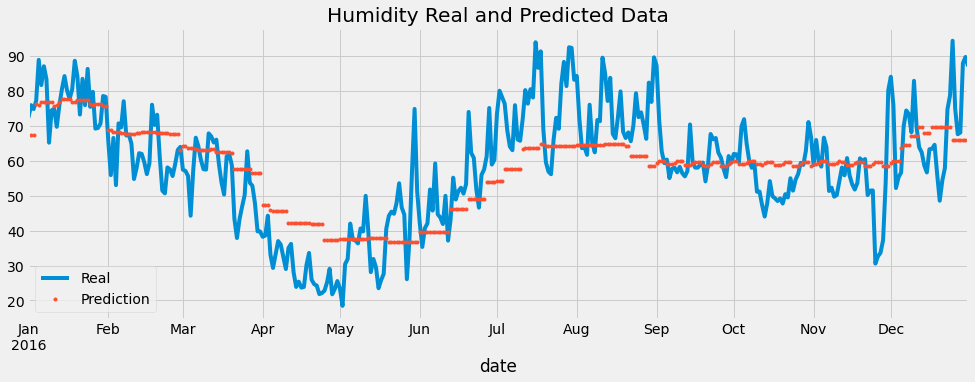

In [153]:
#Training the humidity dataset with the best parameters previsously found.

print("==============HUM - TRAINING WITH THE BEST PARAMETERS==================\n")
regH = xgb.XGBRegressor(booster='gbtree',    
                       n_estimators=3200,
                       objective='reg:squarederror',
                       max_depth=3,
                       learning_rate=0.001,
                       random_state=42)
regH.fit(HUM_input_train, HUM_output_train,
        eval_set=[(HUM_input_train, HUM_output_train), (HUM_input_test, HUM_output_test)],
        verbose=10)
HUM_output_test['humidity_prediction'] = regH.predict(HUM_input_test)
print("Mean Squared Error = ", mean_squared_error(HUM_output_test['humidity'], HUM_output_test['humidity_prediction']))
print("\nMean Absolute Error = ", mean_absolute_error(HUM_output_test['humidity'], HUM_output_test['humidity_prediction']))

HUM_test = HUM_test.merge(HUM_output_test[['humidity_prediction']] , how='left', left_index=True, right_index=True)
ax = HUM_test[['humidity']].plot(figsize=(15, 5))
HUM_test['humidity_prediction'].plot(ax=ax, style='.')
plt.legend(['Real', 'Prediction'])
ax.set_title('Humidity Real and Predicted Data')
plt.show()

In [125]:
#Searching for the best max_depth, learning rate and n of trees hyperparameters among the pre-selected
#groups using grid search.

print("\n==============START GRID SEARCH FOR WIND SPEED==================\n")
params = { 'max_depth': [3,6,10],
           'learning_rate': [0.0001, 0.001, 0.01, 0.05, 0.1],
           'n_estimators': [100, 500, 1000, 1500, 2000]
         }
reg = xgb.XGBRegressor(seed = 42)
opt = GridSearchCV(estimator=reg, 
                   param_grid=params,
                   scoring='neg_mean_squared_error', 
                   verbose=1)
opt.fit(WIND_input_train, WIND_output_train)
print("\nBest Parameters according to Grid Search:", opt.best_params_)
print("\n==============END GRID SEARCH FOR WIND SPEED==================\n")


==============START GRID SEARCH FOR WIND SPEED==================

Fitting 5 folds for each of 75 candidates, totalling 375 fits

Best Parameters according to Grid Search: {'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 500}

==============END GRID SEARCH FOR WIND SPEED==================



==============WIND SPEED - TRAINING WITH THE BEST PARAMETERS==================

[0]	validation_0-rmse:7.07251	validation_1-rmse:7.35617
[10]	validation_0-rmse:7.04566	validation_1-rmse:7.33017
[20]	validation_0-rmse:7.01897	validation_1-rmse:7.30432
[30]	validation_0-rmse:6.99244	validation_1-rmse:7.27864
[40]	validation_0-rmse:6.96608	validation_1-rmse:7.25313
[50]	validation_0-rmse:6.93989	validation_1-rmse:7.22777
[60]	validation_0-rmse:6.91385	validation_1-rmse:7.20258
[70]	validation_0-rmse:6.88797	validation_1-rmse:7.17754
[80]	validation_0-rmse:6.86226	validation_1-rmse:7.15267
[90]	validation_0-rmse:6.83670	validation_1-rmse:7.12795
[100]	validation_0-rmse:6.81131	validation_1-rmse:7.10339
[110]	validation_0-rmse:6.78606	validation_1-rmse:7.07900
[120]	validation_0-rmse:6.76096	validation_1-rmse:7.05476
[130]	validation_0-rmse:6.73603	validation_1-rmse:7.03068
[140]	validation_0-rmse:6.71124	validation_1-rmse:7.00676
[150]	validation_0-rmse:6.68662	validation_1-rmse:6.98299
[16

[1400]	validation_0-rmse:4.59196	validation_1-rmse:4.97159
[1410]	validation_0-rmse:4.58144	validation_1-rmse:4.96146
[1420]	validation_0-rmse:4.57101	validation_1-rmse:4.95142
[1430]	validation_0-rmse:4.56065	validation_1-rmse:4.94142
[1440]	validation_0-rmse:4.55038	validation_1-rmse:4.93155
[1450]	validation_0-rmse:4.54018	validation_1-rmse:4.92169
[1460]	validation_0-rmse:4.53006	validation_1-rmse:4.91195
[1470]	validation_0-rmse:4.52001	validation_1-rmse:4.90226
[1480]	validation_0-rmse:4.51005	validation_1-rmse:4.89268
[1490]	validation_0-rmse:4.50016	validation_1-rmse:4.88316
[1500]	validation_0-rmse:4.49034	validation_1-rmse:4.87368
[1510]	validation_0-rmse:4.48059	validation_1-rmse:4.86430
[1520]	validation_0-rmse:4.47092	validation_1-rmse:4.85498
[1530]	validation_0-rmse:4.46133	validation_1-rmse:4.84576
[1540]	validation_0-rmse:4.45181	validation_1-rmse:4.83656
[1550]	validation_0-rmse:4.44236	validation_1-rmse:4.82748
[1560]	validation_0-rmse:4.43298	validation_1-rmse:4.818

[2790]	validation_0-rmse:3.69910	validation_1-rmse:4.11715
[2800]	validation_0-rmse:3.69554	validation_1-rmse:4.11398
[2810]	validation_0-rmse:3.69200	validation_1-rmse:4.11092
[2820]	validation_0-rmse:3.68849	validation_1-rmse:4.10788
[2830]	validation_0-rmse:3.68501	validation_1-rmse:4.10487
[2840]	validation_0-rmse:3.68160	validation_1-rmse:4.10192
[2850]	validation_0-rmse:3.67815	validation_1-rmse:4.09893
[2860]	validation_0-rmse:3.67476	validation_1-rmse:4.09600
[2870]	validation_0-rmse:3.67141	validation_1-rmse:4.09309
[2880]	validation_0-rmse:3.66809	validation_1-rmse:4.09024
[2890]	validation_0-rmse:3.66477	validation_1-rmse:4.08732
[2900]	validation_0-rmse:3.66150	validation_1-rmse:4.08456
[2910]	validation_0-rmse:3.65824	validation_1-rmse:4.08174
[2920]	validation_0-rmse:3.65500	validation_1-rmse:4.07890
[2930]	validation_0-rmse:3.65181	validation_1-rmse:4.07621
[2940]	validation_0-rmse:3.64864	validation_1-rmse:4.07344
[2950]	validation_0-rmse:3.64548	validation_1-rmse:4.070

[4180]	validation_0-rmse:3.39627	validation_1-rmse:3.87245
[4190]	validation_0-rmse:3.39498	validation_1-rmse:3.87165
[4200]	validation_0-rmse:3.39376	validation_1-rmse:3.87087
[4210]	validation_0-rmse:3.39250	validation_1-rmse:3.87009
[4220]	validation_0-rmse:3.39128	validation_1-rmse:3.86928
[4230]	validation_0-rmse:3.39004	validation_1-rmse:3.86852
[4240]	validation_0-rmse:3.38883	validation_1-rmse:3.86769
[4250]	validation_0-rmse:3.38762	validation_1-rmse:3.86694
[4260]	validation_0-rmse:3.38644	validation_1-rmse:3.86617
[4270]	validation_0-rmse:3.38525	validation_1-rmse:3.86540
[4280]	validation_0-rmse:3.38409	validation_1-rmse:3.86465
[4290]	validation_0-rmse:3.38291	validation_1-rmse:3.86390
[4300]	validation_0-rmse:3.38176	validation_1-rmse:3.86317
[4310]	validation_0-rmse:3.38063	validation_1-rmse:3.86241
[4320]	validation_0-rmse:3.37948	validation_1-rmse:3.86171
[4330]	validation_0-rmse:3.37835	validation_1-rmse:3.86102
[4340]	validation_0-rmse:3.37723	validation_1-rmse:3.860

[5570]	validation_0-rmse:3.27880	validation_1-rmse:3.79613
[5580]	validation_0-rmse:3.27827	validation_1-rmse:3.79602
[5590]	validation_0-rmse:3.27772	validation_1-rmse:3.79589
[5600]	validation_0-rmse:3.27720	validation_1-rmse:3.79578
[5610]	validation_0-rmse:3.27667	validation_1-rmse:3.79568
[5620]	validation_0-rmse:3.27614	validation_1-rmse:3.79557
[5630]	validation_0-rmse:3.27563	validation_1-rmse:3.79546
[5640]	validation_0-rmse:3.27510	validation_1-rmse:3.79536
[5650]	validation_0-rmse:3.27459	validation_1-rmse:3.79527
[5660]	validation_0-rmse:3.27408	validation_1-rmse:3.79516
[5670]	validation_0-rmse:3.27358	validation_1-rmse:3.79507
[5680]	validation_0-rmse:3.27307	validation_1-rmse:3.79498
[5690]	validation_0-rmse:3.27258	validation_1-rmse:3.79490
[5700]	validation_0-rmse:3.27207	validation_1-rmse:3.79480
[5710]	validation_0-rmse:3.27159	validation_1-rmse:3.79472
[5720]	validation_0-rmse:3.27110	validation_1-rmse:3.79465
[5730]	validation_0-rmse:3.27061	validation_1-rmse:3.794

C:\Users\artur\AppData\Local\Temp/ipykernel_7228/760076217.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  WIND_output_test['wind_speed_prediction'] = regW.predict(WIND_input_test)


Mean Squared Error =  14.389384728406345

Mean Absolute Error =  2.909938814822782


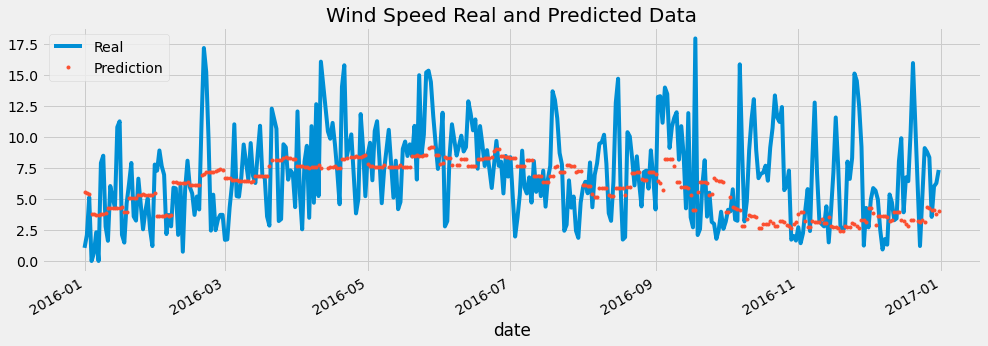

In [154]:
#Training the wind speed dataset with the best parameters previsously found.

print("==============WIND SPEED - TRAINING WITH THE BEST PARAMETERS==================\n")
regW = xgb.XGBRegressor(booster='gbtree',    
                       n_estimators=6000,
                       objective='reg:squarederror',
                       max_depth=3,
                       learning_rate=0.0005,
                       random_state=42)
regW.fit(WIND_input_train, WIND_output_train,
        eval_set=[(WIND_input_train, WIND_output_train), (WIND_input_test, WIND_output_test)],
        verbose=10)
WIND_output_test['wind_speed_prediction'] = regW.predict(WIND_input_test)
print("Mean Squared Error = ", mean_squared_error(WIND_output_test['wind_speed'], WIND_output_test['wind_speed_prediction']))
print("\nMean Absolute Error = ", mean_absolute_error(WIND_output_test['wind_speed'], WIND_output_test['wind_speed_prediction']))

WIND_test = WIND_test.merge(WIND_output_test[['wind_speed_prediction']] , how='left', left_index=True, right_index=True)
ax = WIND_test[['wind_speed']].plot(figsize=(15, 5))
WIND_test['wind_speed_prediction'].plot(ax=ax, style='.')
plt.legend(['Real', 'Prediction'])
ax.set_title('Wind Speed Real and Predicted Data')
plt.show()

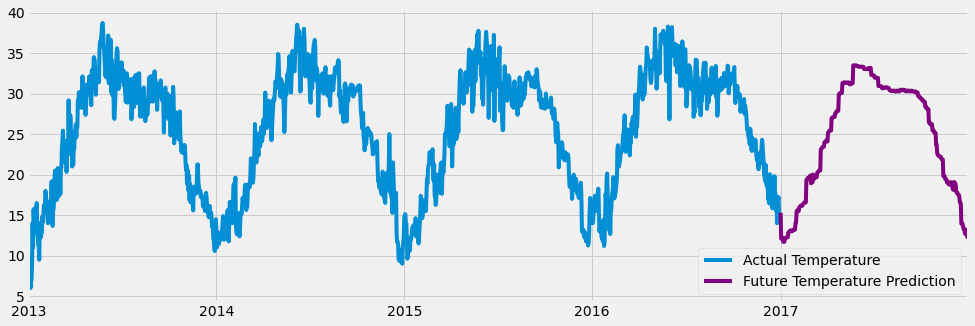

In [155]:
#Predicting temperature for the year of 2017.

data2017 = pd.date_range('2017-01-01', '2017-12-31')
df2017 = pd.DataFrame(index=data2017)
df2017.index = pd.to_datetime(df2017.index)
df2017_2 = create_features(df2017)

dfTEMP = create_features(dfTEMP)
df2017_2['meantemp'] = regT.predict(df2017_2)
dfTEMP_w2017 = pd.concat([dfTEMP, df2017_2])
dTEMP_actual = dfTEMP_w2017.loc[dfTEMP_w2017['year'] < 2017]
dTEMP_future = dfTEMP_w2017.loc[dfTEMP_w2017['year'] == 2017]

fig, ax = plt.subplots(figsize=(15, 5))
dTEMP_actual['meantemp'].plot(ax=ax, label='Actual Temperature')
dTEMP_future['meantemp'].plot(ax=ax, label='Future Temperature Prediction', color='purple')
ax.legend(['Actual Temperature', 'Future Temperature Prediction'])
plt.show()

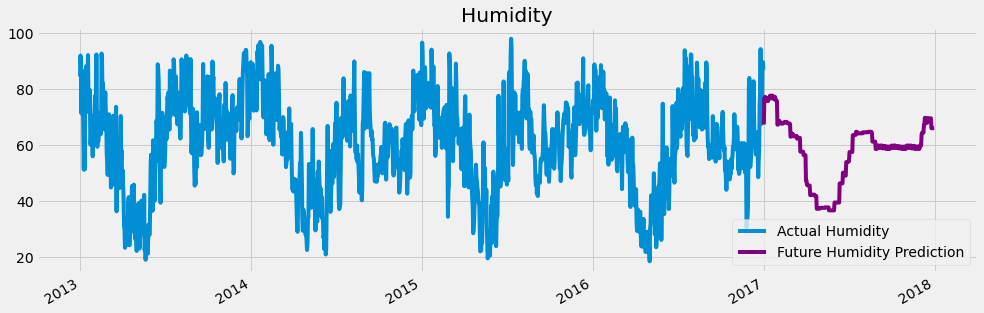

In [156]:
#Predicting humidity for the year of 2017.

data2017 = pd.date_range('2017-01-01', '2017-12-31')
df2017 = pd.DataFrame(index=data2017)
df2017.index = pd.to_datetime(df2017.index)
df2017_2 = create_features(df2017)

dfHUM = create_features(dfHUM)
df2017_2['humidity'] = regH.predict(df2017_2)
dfHUM_w2017 = pd.concat([dfHUM, df2017_2])
dHUM_actual = dfHUM_w2017.loc[dfHUM_w2017['year'] < 2017]
dHUM_future = dfHUM_w2017.loc[dfHUM_w2017['year'] == 2017]

fig, ax = plt.subplots(figsize=(15, 5))
dHUM_actual['humidity'].plot(ax=ax, label='Actual Humidity', title='Humidity')
dHUM_future['humidity'].plot(ax=ax, label='Future Humidity Prediction', color='purple')
ax.legend(['Actual Humidity', 'Future Humidity Prediction'])
plt.show()

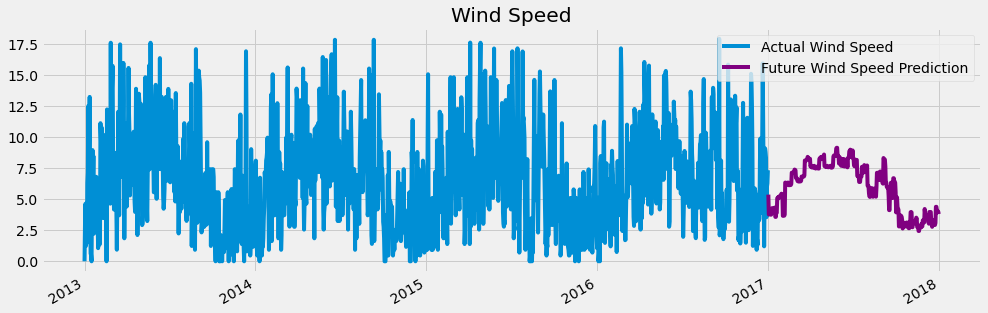

In [157]:
#Predicting wind speed for the year of 2017.

data2017 = pd.date_range('2017-01-01', '2017-12-31')
df2017 = pd.DataFrame(index=data2017)
df2017.index = pd.to_datetime(df2017.index)
df2017_2 = create_features(df2017)

dfWIND = create_features(dfWIND)
df2017_2['wind_speed'] = regW.predict(df2017_2)
dfWIND_w2017 = pd.concat([dfWIND, df2017_2])
dWIND_actual = dfWIND_w2017.loc[dfWIND_w2017['year'] < 2017]
dWIND_future = dfWIND_w2017.loc[dfWIND_w2017['year'] == 2017]

fig, ax = plt.subplots(figsize=(15, 5))
dWIND_actual['wind_speed'].plot(ax=ax, label='Actual Wind Speed', title='Wind Speed')
dWIND_future['wind_speed'].plot(ax=ax, label='Future Wind Speed Prediction', color='purple')
ax.legend(['Actual Wind Speed', 'Future Wind Speed Prediction'])
plt.show()